# Ejemplo práctico: Clasificación con datos desbalanceados

En este ejercicio, evaluaremos diferentes técnicas y modelos de clasificación aplicados a un dataset altamente desbalanceado. Además compararemos los diferentes algoritmos de resampling combinados con los modelos de clasificación.


In [ ]:
# Imports y configuración
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc, average_precision_score,
                             matthews_corrcoef, RocCurveDisplay, PrecisionRecallDisplay)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier

# Opcional: fijar semilla
RANDOM_STATE = 42



### Dataset
Utilizamos el dataset 'creditcard.cvs', sobre fraudes bancarios realizados con tarjeta de crédito. El dataset es altamente desbalanceado. Está compuesto por 30 variables, de las cuales 28 son resultado de un proceso de PCA, y las otras dos variables 'Time' y 'Ammount', que no fueron incluidas. Todas las variables se estandarizan con StandardScaler().

In [ ]:
# Cargar dataset
df = pd.read_csv('creditcard.csv')
print('Shape:', df.shape)
print('Porcentaje de cada clase:')
print(df['Class'].value_counts(normalize=True) * 100)
df.head()

Shape: (284807, 31)
Porcentaje de cada clase:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


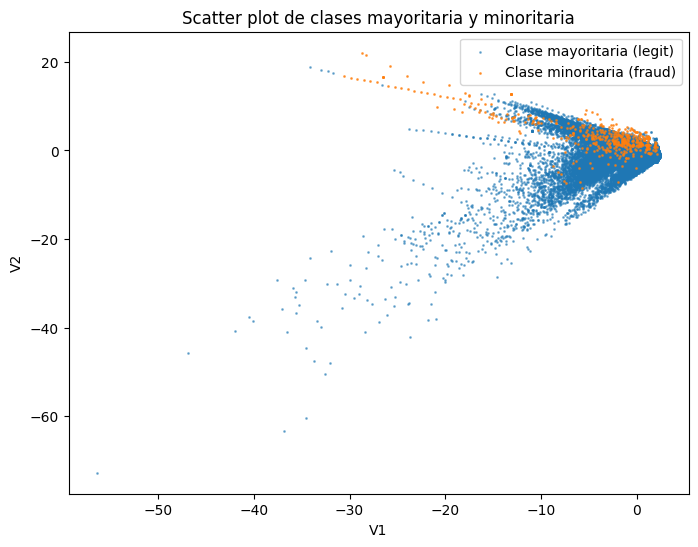

In [22]:
# Visualización de clases mayoritaria y minoritaria con scatter plot
plt.figure(figsize=(8, 6))
# Selección de V1 y V2 para el scatter plot
plt.scatter(df[df['Class'] == 0]['V1'], df[df['Class'] == 0]['V2'], 
            s=1, alpha=0.5, label='Clase mayoritaria (legit)')
plt.scatter(df[df['Class'] == 1]['V1'], df[df['Class'] == 1]['V2'], 
            s=1, alpha=0.7, label='Clase minoritaria (fraud)')
plt.xlabel('V1')
plt.ylabel('V2')
plt.title('Scatter plot de clases mayoritaria y minoritaria')
plt.legend()
plt.show()

In [ ]:
# Preparar X, y.
X = df.drop(columns=['Class'])
y = df['Class']

# Escalar todo el dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# Partición del conjunto de datos.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, 
                                                    stratify=y, random_state=RANDOM_STATE)
print('Train class distribution:', Counter(y_train))
print('Test class distribution:', Counter(y_test))

Train class distribution: Counter({0: 213236, 1: 369})
Test class distribution: Counter({0: 71079, 1: 123})


### Nueva Métrica - Mathews Correlation Coefficient

$$
MCC \frac{TP \times TN - FN \times FP}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

El coeficiente de correlación de Matthews (MCC) es una medida de la calidad de las clasificaciones binarias (de dos clases), que oscila entre -1 y +1. Una puntuación de +1 representa una clasificación perfecta, 0 un clasificador aleatorio y -1 una clasificación inversa.
Tiene un valor alto si el clasificador tiene un buen rendimiento en los cuatro cuadrantes de la matriz de confusión

In [7]:

# Función para evaluar modelos
def evaluate_model(name, model, X_test, y_test, show_plots=False):
    y_pred = model.predict(X_test)
    y_proba = None
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
    elif hasattr(model, 'decision_function'):
        try:
            y_proba = model.decision_function(X_test)
        except Exception:
            y_proba = None

    print(f"== {name} ==")
    print(classification_report(y_test, y_pred, digits=4, target_names=['legit', 'fraud'], zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)

    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f'ROC-AUC: {roc_auc:.4f} | PR-AUC (avg precision): {pr_auc:.4f} | MCC: {mcc:.4f}\n')

    results = {'model': name, 'roc_auc': roc_auc, 'pr_auc': pr_auc, 'mcc': mcc}

    if show_plots and (y_proba is not None):
        RocCurveDisplay.from_predictions(y_test, y_proba,pos_label='fraud')
        plt.title(f'ROC curve - {name}')
        plt.show()
        PrecisionRecallDisplay.from_predictions(y_test, y_proba)
        plt.title(f'Precision-Recall curve - {name}')
        plt.show()

    return results, y_pred, y_proba


### Regresión Logística sin balanceo


In [8]:
# 1) Regresión logística sin rebalanceo
lr_base = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
lr_base.fit(X_train, y_train)
res_base, pred_base, proba_base = evaluate_model('Logistic (baseline)', lr_base, X_test, y_test)

== Logistic (baseline) ==
              precision    recall  f1-score   support

       legit     0.9993    0.9998    0.9996     71079
       fraud     0.8352    0.6179    0.7103       123

    accuracy                         0.9991     71202
   macro avg     0.9173    0.8088    0.8549     71202
weighted avg     0.9991    0.9991    0.9991     71202

Confusion matrix:
 [[71064    15]
 [   47    76]]
ROC-AUC: 0.9621 | PR-AUC (avg precision): 0.7177 | MCC: 0.7180



### Regresión Logística con class_weight='balanced'

Class weight evalua el error, otorgándole más peso a los errores de la clase minoritaria, de una forma iversamente proporcional a la cantidad de observaciones de la clase

In [9]:
# 2) Regresión Logística con class_weight='balanced'
lr_bal = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=RANDOM_STATE)
lr_bal.fit(X_train, y_train)
res_lr_bal, pred_lr_bal, proba_lr_bal = evaluate_model("Logistic (class_weight='balanced')", lr_bal, X_test, y_test)

== Logistic (class_weight='balanced') ==
              precision    recall  f1-score   support

       legit     0.9998    0.9770    0.9883     71079
       fraud     0.0625    0.8862    0.1168       123

    accuracy                         0.9768     71202
   macro avg     0.5311    0.9316    0.5525     71202
weighted avg     0.9982    0.9768    0.9868     71202

Confusion matrix:
 [[69444  1635]
 [   14   109]]
ROC-AUC: 0.9726 | PR-AUC (avg precision): 0.7073 | MCC: 0.2319



### Oversampling (RandomOverSampler)

Se emplea un modelo de sobremuestreo que permite incrementar las observaciones para la clase más pequeña en una determinada proporción, que para este caso la nueva clase minoritaria será del tamaño de la mitad de la clase mayoritaría. ¿Por qué no usar un tamaño igual a la clase?
* Puede producir Overfitting
* Puede corromper el comportamiento natural de los datos y sus relaciones
* Si la cantidad de la variable minoritaria es mucho menor puede llevar a conclusiones erroneas al intentar equilibrar completamente los datos e inducir valores erroneos en las metricas de desempeño.

Esta técnica no genera datos sinteticos nuevos, duplica aleatoriamente los datos de la clase minoritaria hasta alcanzar la proporción indicada

In [10]:
# 3) Oversampling (RandomOverSampler) aplicado en datos de entrenamiento 
ros = RandomOverSampler(random_state=RANDOM_STATE)
lr_ros_pipe = ImbPipeline([('ros', ros), ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
lr_ros_pipe.fit(X_train, y_train)
res_ros, pred_ros, proba_ros = evaluate_model('Logistic (RandomOverSampler)', lr_ros_pipe, X_test, y_test)

== Logistic (RandomOverSampler) ==
              precision    recall  f1-score   support

       legit     0.9998    0.9772    0.9884     71079
       fraud     0.0630    0.8862    0.1177       123

    accuracy                         0.9771     71202
   macro avg     0.5314    0.9317    0.5530     71202
weighted avg     0.9982    0.9771    0.9869     71202

Confusion matrix:
 [[69459  1620]
 [   14   109]]
ROC-AUC: 0.9727 | PR-AUC (avg precision): 0.7040 | MCC: 0.2329



### Undersampling (NearMiss)

NearMiss es un algoritmo que permite seleccionar ciertos puntos bajo la logica de que definiendo bien una frontera dedesición el modelo puede aprender con mayor certeza las caracteristicas que diferencian a una clase de otra. Lo realiza por medio de 3 metodologías posibles: 
1. Conservar los puntos de la clase mayoritaria que son vecinos directos de los puntos de la clase minoritaria
2. Conservar los puntos de la clase mayoritaria que en promedio estan más cerca a todos los puntos de la clase minoritaria
3. Conservar los puntos de la clase mayoritaria que tienen vecinos muy cercanos a los puntos de la clase minoritaria.

En este ejemplo se usa la segunda metodología.

In [11]:
# 4) Undersampling (NearMiss) aplicado en datos de entrenamiento
nm = NearMiss(version=2)
lr_nm_pipe = ImbPipeline([('nm', nm), ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
lr_nm_pipe.fit(X_train, y_train)
res_nm, pred_nm, proba_nm = evaluate_model('Logistic (NearMiss)', lr_nm_pipe, X_test, y_test)

== Logistic (NearMiss) ==
              precision    recall  f1-score   support

       legit     0.9997    0.3249    0.4904     71079
       fraud     0.0024    0.9431    0.0048       123

    accuracy                         0.3260     71202
   macro avg     0.5011    0.6340    0.2476     71202
weighted avg     0.9980    0.3260    0.4896     71202

Confusion matrix:
 [[23094 47985]
 [    7   116]]
ROC-AUC: 0.8251 | PR-AUC (avg precision): 0.0241 | MCC: 0.0238



### SMOTETomek (híbrido)
SMOTETomek Es un algoritmo que combina al tiempo, las dos metodologías anteriores. Esto lo hace creando nuevos datos sínteticos de la clase minoritaria y elimina las observaciones de la clase mayoritaria que se encuenran en la frontera de desición y que generan mucho ruido, es decir, no aportan información.
Si bien su metodología es robusta, presenta unas desventajas a considerar: 
* Tiene un costo computacional alto
* Dado que genera datos sínteticos usando interpolación de datos, es decir, crea uno nuevo en el medio de dos de ellos, el modelo es sensible a valores atípicos
* Si el los datos son extremadamente desbalanceado, puede generar observaciones que no aportan información al modelo

In [12]:
# 5) SMOTETomek (hibrido) aplicado en datos de entrenamiento
smtt = SMOTETomek(random_state=RANDOM_STATE)
lr_smtt_pipe = ImbPipeline([('smtt', smtt), ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
lr_smtt_pipe.fit(X_train, y_train)
res_smtt, pred_smtt, proba_smtt = evaluate_model('Logistic (SMOTETomek)', lr_smtt_pipe, X_test, y_test)

== Logistic (SMOTETomek) ==
              precision    recall  f1-score   support

       legit     0.9998    0.9756    0.9875     71079
       fraud     0.0591    0.8862    0.1108       123

    accuracy                         0.9754     71202
   macro avg     0.5295    0.9309    0.5492     71202
weighted avg     0.9982    0.9754    0.9860     71202

Confusion matrix:
 [[69344  1735]
 [   14   109]]
ROC-AUC: 0.9726 | PR-AUC (avg precision): 0.7107 | MCC: 0.2253



### Random Forest
Random Forest es un modelo robusto que combina bagging (bootstrap aggregation) con muchos árboles de decisión, lso cuales se ajustan aleatoriamente a cada grupo de variables resampleado.


In [13]:
# 6) RandomForest sin rebalanceo
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
res_rf, pred_rf, proba_rf = evaluate_model('RandomForest (baseline)', rf, X_test, y_test)

== RandomForest (baseline) ==
              precision    recall  f1-score   support

       legit     0.9997    0.9999    0.9998     71079
       fraud     0.9429    0.8049    0.8684       123

    accuracy                         0.9996     71202
   macro avg     0.9713    0.9024    0.9341     71202
weighted avg     0.9996    0.9996    0.9996     71202

Confusion matrix:
 [[71073     6]
 [   24    99]]
ROC-AUC: 0.9455 | PR-AUC (avg precision): 0.8408 | MCC: 0.8709



### Balanced Bagging Classifier (árbol de decisión base)

En cada iteración, antes de entrenar el modelo base (por ejemplo, un árbol de decisión), realiza un muestreo balanceado del conjunto de entrenamiento, seleccionando la misma cantidad de ejemplos de cada clase, usando submuestreo de la clase mayoritaria o sobremuestreo de la minoritaria.

De esta forma, cada modelo base se entrena sobre un subconjunto equilibrado, lo que mejora la capacidad del ensemble para aprender patrones de la clase minoritaria.

Al final, la predicción se realiza por votación mayoritaria de todos los modelos base.

In [14]:
# 7) Balanced Bagging Classifier (árbol de decisión base)
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
                                sampling_strategy='auto', replacement=False, random_state=RANDOM_STATE, n_estimators=10)
bbc.fit(X_train, y_train)
res_bbc, pred_bbc, proba_bbc = evaluate_model('BalancedBaggingClassifier', bbc, X_test, y_test)

== BalancedBaggingClassifier ==
              precision    recall  f1-score   support

       legit     0.9998    0.9758    0.9876     71079
       fraud     0.0595    0.8862    0.1116       123

    accuracy                         0.9756     71202
   macro avg     0.5297    0.9310    0.5496     71202
weighted avg     0.9982    0.9756    0.9861     71202

Confusion matrix:
 [[69357  1722]
 [   14   109]]
ROC-AUC: 0.9692 | PR-AUC (avg precision): 0.3919 | MCC: 0.2261



### Resultados

,model,roc_auc,pr_auc,mcc
5,RandomForest (baseline),0.945506,0.840805,0.870938
7,BalancedRandomForest,0.976523,0.719079,0.344740
0,Logistic (baseline),0.962100,0.717658,0.717950
4,Logistic (SMOTETomek),0.972555,0.710708,0.225313
1,Logistic (class_weight='balanced'),0.972636,0.707345,0.231893
2,Logistic (RandomOverSampler),0.972748,0.704011,0.232929
6,BalancedBaggingClassifier,0.969238,0.391934,0.226138
8,IsolationForest,0.946863,0.163065,0.272936
3,Logistic (NearMiss),0.825083,0.024113,0.023772


<Figure size 800x600 with 0 Axes>

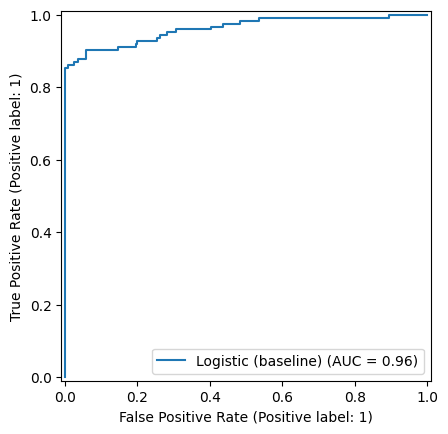

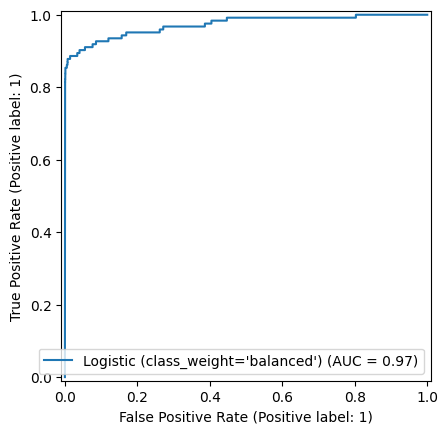

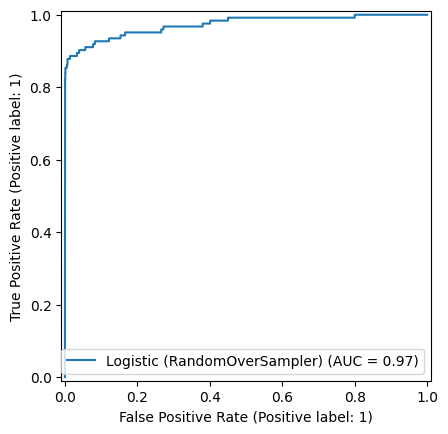

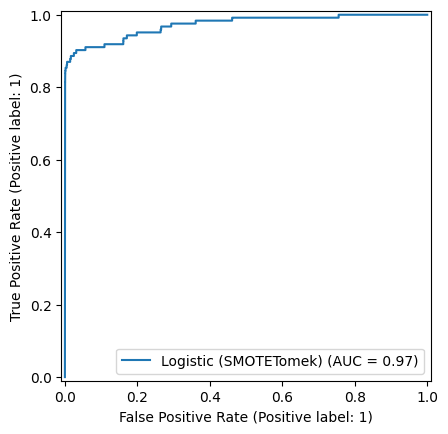

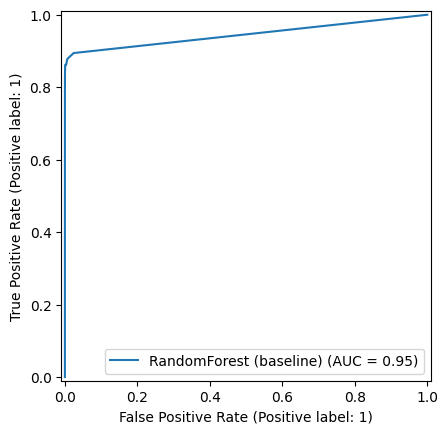

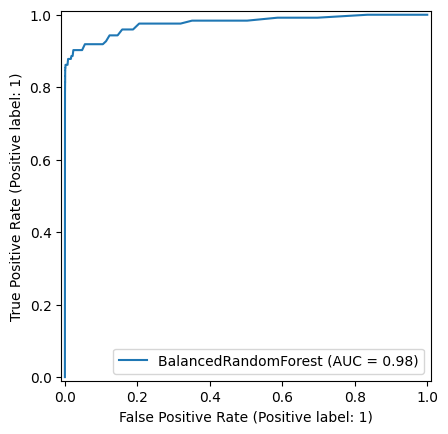

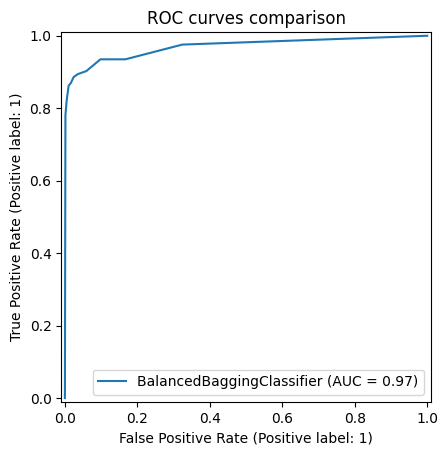

<Figure size 800x600 with 0 Axes>

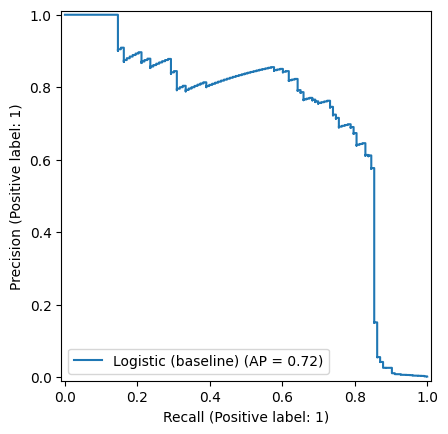

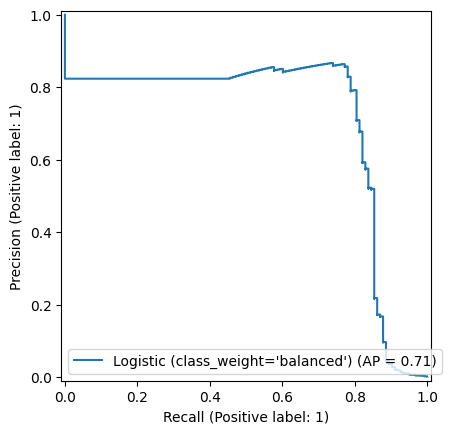

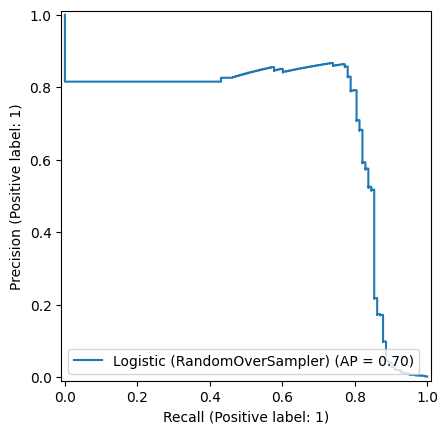

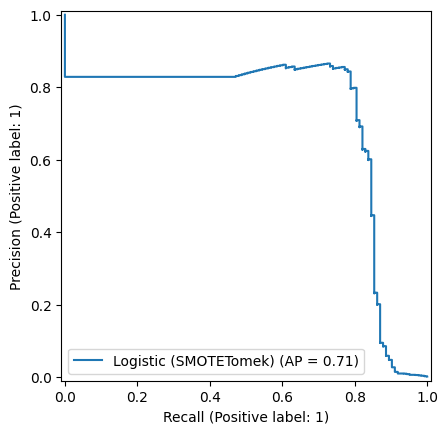

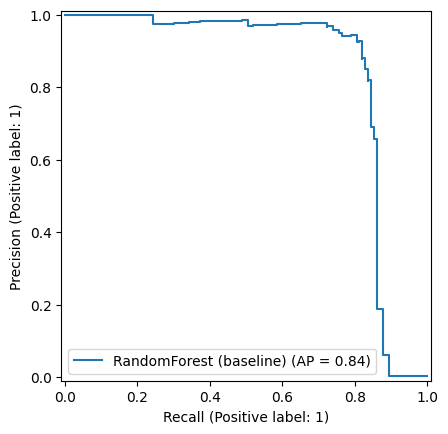

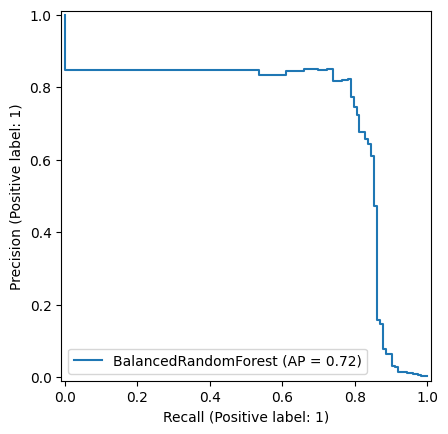

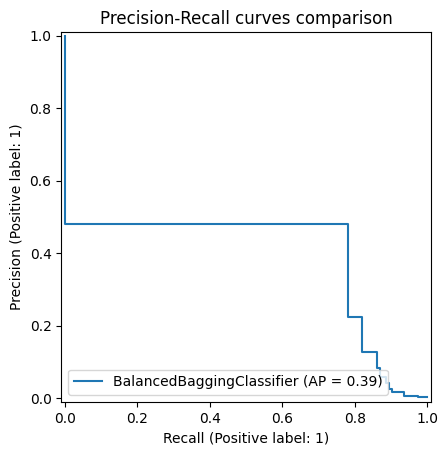

In [17]:

# Recolectar resultados
results = [res_base, res_lr_bal, res_ros, res_nm, res_smtt, res_rf, res_bbc, res_brf, res_iso]
df_results = pd.DataFrame(results)
display(df_results.sort_values('pr_auc', ascending=False))

# Curvas ROC comparativas
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
plt.figure(figsize=(8,6))
for name, score in [('Logistic (baseline)', proba_base), 
                    ("Logistic (class_weight='balanced')", proba_lr_bal),
                    ('Logistic (RandomOverSampler)', proba_ros),
                    ('Logistic (SMOTETomek)', proba_smtt),
                    ('RandomForest (baseline)', proba_rf),
                    ('BalancedRandomForest', proba_brf),
                    ('BalancedBaggingClassifier', proba_bbc)]:
    if score is None:
        continue
    RocCurveDisplay.from_predictions(y_test, score, name=name)
plt.title('ROC curves comparison')
plt.legend(loc='lower right')
plt.show()

# Curvas Precision-Recall comparativas
plt.figure(figsize=(8,6))
for name, score in [('Logistic (baseline)', proba_base), 
                    ("Logistic (class_weight='balanced')", proba_lr_bal),
                    ('Logistic (RandomOverSampler)', proba_ros),
                    ('Logistic (SMOTETomek)', proba_smtt),
                    ('RandomForest (baseline)', proba_rf),
                    ('BalancedRandomForest', proba_brf),
                    ('BalancedBaggingClassifier', proba_bbc)]:
    if score is None:
        continue
    PrecisionRecallDisplay.from_predictions(y_test, score, name=name)
plt.title('Precision-Recall curves comparison')
plt.legend(loc='lower left')
plt.show()
